In [1]:
import sys
sys.path.insert (0,'../python')
import bbll
import multiprocessing
import json
from array import array
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
from importlib import reload
from torch.utils.data import DataLoader, TensorDataset
import swats

import numpy as np 
import matplotlib.pyplot as plt
import dgl
import dgl.function as fn

Welcome to JupyROOT 6.22/06


Using backend: pytorch


In [2]:
class GNNLayer(nn.Module):
    def __init__(self, node_dims, edge_dims, output_dims):
        super(GNNLayer, self).__init__()
        self.W_msg = nn.Linear( node_dims+edge_dims, output_dims)
        self.W_apply = nn.Linear(output_dims+node_dims, output_dims)
    def message_func(self,edges):
        return {'m': F.relu(self.W_msg(torch.cat([edges.src['h'], edges.data['h']], 2)))}
    def forward(self, g, node_features, edge_features):
        with g.local_scope():
            g.ndata['h'] = node_features
            g.edata['h'] = edge_features
            g.update_all(self.message_func, fn.sum('m', 'h_neigh'))
            g.ndata['h'] = F.relu(self.W_apply(torch.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']

In [3]:
class GCN(nn.Module):
    def __init__(self, ndim_in,edim,nclass,n_nodes,h_dim):
        super(GCN, self).__init__()
        self.n_nodes = n_nodes
        self.gcn1=GNNLayer(ndim_in,edim,50)
        self.gcn2=GNNLayer(50,edim,50)
        self.gcn3=GNNLayer(50,edim,50)
        self.gcn4=GNNLayer(50,edim,50)
        self.ln1 = nn.Linear(50,h_dim)
        self.ln2 = nn.Linear(h_dim,h_dim)
        self.ln3 = nn.Linear(h_dim,1)
        self.out_act = nn.Sigmoid()

    def forward(self, g, nfeats, efeats):
        nfeats = torch.transpose(nfeats,0,1)
        efeats = torch.transpose(efeats,0,1)
        nf1=self.gcn1(g,nfeats,efeats)
        nf2=self.gcn2(g,nf1,efeats)
        nf3=self.gcn3(g,nf2,efeats)
        nf4=self.gcn4(g,nf3,efeats)
        nf4=torch.transpose(nf4,0,1)
        gnn_out = torch.mean(nf4,1)
        #gnn_out = nf4.reshape(-1,self.n_nodes*50)
        l1 = F.relu(self.ln1(gnn_out))
        l2 = F.relu(self.ln2(l1))
        out = self.ln3(l2)
        out = self.out_act(out)
        return(out)

In [4]:
weight_name = "weightr"
num_fold = 5
variable_names=[weight_name,'MJJ','dEtaJJ','PtL1','EtaL1','PhiL1','EL1','PIDL1',
               'PtL2','EtaL2','PhiL2','EL2','PIDL2',
               'PtL3','EtaL3','PhiL3','EL3','PIDL3',
               'PtL4','EtaL4','PhiL4','EL4','PIDL4',
               'PtJ1','EtaJ1','PhiJ1','EJ1','PIDJ1',
               'PtJ2','EtaJ2','PhiJ2','EJ2','PIDJ2']
unused_variable=[weight_name,'MJJ','dEtaJJ']
#unused_variable=[weight_name,"is_em","is_me","is_ee","is_mm",'process_id']
#unused_variable=[weight_name,"is_em","is_me",'process_id',"m_hh_truth","bb_m","bb_deltar","ll_m"]
dim = len(variable_names)-len(unused_variable)

In [5]:
parameter_list = {}
parameter_list["sample_path"] = "/home/shuzhou/Documents/diff-4l/mva/sample-train-1220"
#parameter_list["sample_path"] = "/lustre/samples/di-higgs/sample-applied-0501"
parameter_list["sample_name1"] = "tree_ewk.root"
#parameter_list["sample_name2"] = "tree_bkg_reweighted.root"
parameter_list["sample_name2"] = "tree_QCD.root"
parameter_list["ntuple_name"] = ["tree_NOMINAL"]
parameter_list["sample_num"] = 2 
parameter_list["variable_list"] = variable_names 
parameter_list["weight_name"] = weight_name
parameter_list["unused_variable"] = unused_variable
parameter_list["label_list"] = [1,0]
parameter_list["do_reweight"] = True
parameter_list["cut_num"] = 1
parameter_list["cut1_type"] = "all"
parameter_list["cut1"] = '(DF["MJJ"]>300)&((DF["dEtaJJ"]>2.0)|(DF["dEtaJJ"]<-2.0))'
parameter_list["cut1_samples"] = [1]
parameter_list["ispDNN"] = False
parameter_list["tag_variable"] = "m_hh_truth"
parameter_list["target_sample"] = [1]
parameter_list["sample_to_fill"] = [2,3,4]
parameter_list["get_correlation_matrix"] = True
parameter_list["figures_path"] = "../figures/1213"
parameter_list["do_shuffle"] = True
parameter_list["do_normalization"]=True
parameter_list["ratio_list"] = [1,1]

In [6]:
out_list = bbll.create_dataset(parameter_list)

Start loading files


../python/bbll/preprocess.py:335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame_list["sample"+str(i)]["label"] = label_list[i] # create label to each sample
/home/shuzhou/anaconda3/lib/python3.8/site-packages/cuda_guass_normal/__init__.py:216: RuntimeWarning: invalid value encountered in double_scalars
  result[i,j] = result[i,j]/sqrt(var_vec[i]*var_vec[j])
/home/shuzhou/anaconda3/lib/python3.8/site-packages/cuda_guass_normal/__init__.py:218: RuntimeWarning: invalid value encountered in double_scalars
  result[j,i] = result[j,i]/sqrt(var_vec[i]*var_vec[j])


correlation matrix saved at: ../figures/1213
correlation matrix saved at: ../figures/1213
sample1 yield before reweight is: 19.718600701136758
sample1 yield after reweight is: 86.09479026239009
sample2 yield before reweight is: 86.09479026239009
sample2 yield after reweight is: 86.09479026239009
dataset is successfully constructed!


In [7]:
print(out_list)

{'mean_vec': array([[ 1.05144311e+02],
       [ 7.01334829e-03],
       [ 1.77117649e-02],
       [ 1.97534816e+02],
       [ 2.60999339e-01],
       [ 4.17904307e+01],
       [ 2.27227347e-03],
       [ 6.67722697e-03],
       [ 8.02895054e+01],
       [-2.60999339e-01],
       [ 1.06150103e+02],
       [ 1.60037723e-02],
       [-1.47433693e-02],
       [ 2.04010361e+02],
       [ 2.20223340e-01],
       [ 4.04319412e+01],
       [ 5.42624709e-03],
       [ 3.37631892e-03],
       [ 8.00818100e+01],
       [-2.20223340e-01],
       [ 1.65801115e+02],
       [ 1.62458253e-03],
       [ 7.16829412e-03],
       [ 6.35435486e+02],
       [ 1.00000000e+01],
       [ 8.26034770e+01],
       [-2.30200634e-03],
       [ 1.40653394e-02],
       [ 4.60050267e+02],
       [-1.00000000e+01]]), 'var_vec': array([[5.11007407e+03],
       [1.45711314e+00],
       [3.28738954e+00],
       [2.95260675e+04],
       [1.46703702e+02],
       [7.89512100e+02],
       [1.50277865e+00],
       [3.28966956e

In [8]:
drop_variable = unused_variable.copy()
drop_variable.append("label")

train_df, test_df = bbll.split_sample(out_list, 0.2)

train_label_df = train_df["label"]
train_weight_df = train_df[weight_name]
test_label_df = test_df["label"]
test_weight_df = test_df[weight_name]
train_data_df = train_df.drop(columns = drop_variable)
test_data_df = test_df.drop(columns = drop_variable)

In [9]:
train_data_df.describe()

PtL1          EtaL1          PhiL1            EL1  \
count  177848.000000  177848.000000  177848.000000  177848.000000   
mean      113.226960       0.000923       0.010390     203.063897   
std        77.935166       1.159533       1.814611     174.624953   
min        10.064951      -2.698472      -3.141572      21.617752   
25%        63.750453      -0.860612      -1.559730      92.964073   
50%        89.504367       0.001839       0.022004     148.455813   
75%       135.406906       0.862652       1.579132     250.242009   
max      1660.378125       2.699381       3.141486    3278.250398   

               PIDL1           PtL2          EtaL2          PhiL2  \
count  177848.000000  177848.000000  177848.000000  177848.000000   
mean        0.297445      43.835283      -0.002083       0.003401   
std        12.096129      30.865835       1.192550       1.814297   
min       -13.000000       7.001303      -2.698790      -3.141542   
25%       -13.000000      25.424513      -0.890779      -1.567733   
50%        11.000000      36.538992       0.000082       0.010221   
75%        13.000000      51.107572       0.879024       1.570493   
max        13.000000     443.960344       2.699302       3.141555   

                 EL2          PIDL2  ...           PtJ1          EtaJ1  \
count  177848.000000  177848.000000  ...  177848.000000  177848.000000   
mean       81.216547      -0.297445  ...     190.309894      -0.000570   
std        72.759796      12.096129  ...     125.849723       2.031011   
min         7.050194     -13.000000  ...      31.093488      -4.499182   
25%        37.061442     -13.000000  ...     104.932455      -1.773688   
50%        58.246696     -11.000000  ...     157.644258       0.008461   
75%        99.871651      13.000000  ...     237.997368       1.771357   
max      1767.748763      13.000000  ...    2161.905830       4.499205   

               PhiJ1            EJ1     PIDJ1           PtJ2          EtaJ2  \
count  177848.000000  177848.000000  177848.0  177848.000000  177848.000000   
mean        0.004974     753.701448      10.0      97.223394      -0.004732   
std         1.813262     679.650301       0.0      70.745538       2.286515   
min        -3.141517      42.394392      10.0      30.000410      -4.499633   
25%        -1.563309     278.596520      10.0      51.585008      -2.053959   
50%         0.004768     528.453474      10.0      75.820840      -0.015072   
75%         1.580278     999.794721      10.0     117.201121       2.039351   
max         3.141565    6654.117734      10.0    1232.588995       4.499864   

               PhiJ2            EJ2     PIDJ2  
count  177848.000000  177848.000000  177848.0  
mean        0.000678     551.418320     -10.0  
std         1.811526     581.832069       0.0  
min        -3.141546      30.552918     -10.0  
25%        -1.565988     156.901299     -10.0  
50%         0.000834     342.657228     -10.0  
75%         1.564629     727.304935     -10.0  
max         3.141561    6513.767719     -10.0  

[8 rows x 30 columns]

In [10]:
import cuda_guass_normal
reload(cuda_guass_normal)
mean_vec = out_list["mean_vec"]
var_vec = out_list["var_vec"]
train_data = cuda_guass_normal.guass_normal_cuda(train_data_df.values, mean_vec, var_vec)
test_data = cuda_guass_normal.guass_normal_cuda(test_data_df.values, mean_vec, var_vec)
train_label = train_label_df.values
test_label = test_label_df.values
train_weight = train_weight_df.values
test_weight = test_weight_df.values

training_variable = train_data_df.columns.values.tolist()
print(training_variable)

['PtL1', 'EtaL1', 'PhiL1', 'EL1', 'PIDL1', 'PtL2', 'EtaL2', 'PhiL2', 'EL2', 'PIDL2', 'PtL3', 'EtaL3', 'PhiL3', 'EL3', 'PIDL3', 'PtL4', 'EtaL4', 'PhiL4', 'EL4', 'PIDL4', 'PtJ1', 'EtaJ1', 'PhiJ1', 'EJ1', 'PIDJ1', 'PtJ2', 'EtaJ2', 'PhiJ2', 'EJ2', 'PIDJ2']


In [11]:
num_nodes = 6
nfeature_dim=5
efeature_dim=3

In [12]:
train_edge = np.zeros((train_data_df.values.shape[0],num_nodes*(num_nodes-1)*efeature_dim))

In [13]:
train_edge.shape

(177848, 90)

In [14]:
def create_efeature(data, weight, num_nodes, nfeature_dim, efeature_dim):
    temp = np.zeros((data.shape[0],num_nodes*(num_nodes-1)*efeature_dim))
    counter = 0
    for i in range(0,num_nodes):
        for j in range(0,num_nodes):
            if(i==j): 
                continue
            temp[:,counter*3+0]=data[:,i*5+1]-data[:,j*5+1]
            temp[:,counter*3+1]=data[:,i*5+2]-data[:,j*5+2]
            temp[:,counter*3+2]=np.sqrt(temp[:,0]*temp[:,0]+temp[:,1]*temp[:,1])
            counter+=1
    mean_vec, var_vec = cuda_guass_normal.cuda_mean_var(temp, weight)
    result = cuda_guass_normal.guass_normal_cuda(temp, mean_vec, var_vec)
    result = result.reshape(-1,num_nodes*(num_nodes-1),efeature_dim)
    return(result)
    

In [15]:
def create_edge(num_nodes):
    edge_ind = torch.ones((2,num_nodes*(num_nodes-1)))
    counter = 0
    for i in range(0,num_nodes):
        for j in range(0,num_nodes):
            if(i==j):
                continue
            edge_ind[0,counter]=i
            edge_ind[1,counter]=j
            counter+=1
    edge_ind=edge_ind.long()
    print(edge_ind)
    return(edge_ind)

In [16]:
edge_ind = create_edge(num_nodes)
train_efeature = create_efeature(train_data_df.values,train_weight, num_nodes, nfeature_dim, efeature_dim)
test_efeature = create_efeature(test_data_df.values, test_weight, num_nodes, nfeature_dim, efeature_dim)

tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
         4, 5, 5, 5, 5, 5],
        [1, 2, 3, 4, 5, 0, 2, 3, 4, 5, 0, 1, 3, 4, 5, 0, 1, 2, 4, 5, 0, 1, 2, 3,
         5, 0, 1, 2, 3, 4]])


In [17]:
print(test_efeature.shape)

(44463, 30, 3)


In [18]:
train_node_info = train_data.reshape(-1,num_nodes,nfeature_dim)
print(train_node_info.shape)
test_node_info = test_data.reshape(-1,num_nodes,nfeature_dim)
print(test_node_info.shape)

(177848, 6, 5)
(44463, 6, 5)


In [19]:
g = dgl.graph((edge_ind[0],edge_ind[1]))
print(g)

Graph(num_nodes=6, num_edges=30,
      ndata_schemes={}
      edata_schemes={})


In [20]:
train_node_tensor = torch.tensor(train_node_info, dtype=torch.float)
train_edge_tensor = torch.tensor(train_efeature, dtype=torch.float)
train_target_tensor = torch.tensor(train_label, dtype=torch.float)
train_weight_tensor = torch.tensor(train_weight, dtype=torch.float)
test_node_tensor = torch.tensor(test_node_info, dtype=torch.float)
test_edge_tensor = torch.tensor(test_efeature, dtype=torch.float)
test_target_tensor = torch.tensor(test_label, dtype=torch.float)
test_weight_tensor = torch.tensor(test_weight, dtype=torch.float)
#create datasets:
trainDataset = TensorDataset(train_weight_tensor, train_node_tensor, train_edge_tensor, train_target_tensor)
testDataset = TensorDataset(test_weight_tensor, test_node_tensor, test_edge_tensor, test_target_tensor)
#create dataloader:
trainLoader = DataLoader(trainDataset, batch_size=500,shuffle=False, num_workers=5,pin_memory=True)
testLoader = DataLoader(testDataset, batch_size=500,shuffle=False, num_workers=5,pin_memory=True)

In [21]:
device = torch.device("cuda") 
model = GCN(nfeature_dim,efeature_dim,2,num_nodes,200).to(device)
loss_function = nn.BCELoss().cuda()
optimizer = swats.SWATS(model.parameters())

In [22]:
def train(model, device, train_loader, loss_function, optimizer, epoch, num_class, graph):
    model.train()
    average_loss=0
    batch_n=0
    for batch_idx, (sample_weight, node, edge, target) in enumerate(train_loader):
        batch_n=batch_n+1
        sample_weight, node, edge, target = sample_weight.to(device), node.to(device), edge.to(device), target.to(device)
        graph = graph.to(device)
        optimizer.zero_grad()
        output = model(graph,node,edge)
        #my_weight=sample_weight/sample_weight.mean()
        if(num_class == 2):
            loss_function.weight = sample_weight/sample_weight.mean()
            output=output.reshape(-1)
            loss = loss_function(output, target)
            #loss = custom_loss(output, target,my_weight)
            loss.backward()
            average_loss=average_loss+loss.item()
        else:
            target = target.long()
            loss = loss_function(output, target)
            loss = loss * sample_weight/sample_weight.mean()
            loss = loss.mean()
            loss.backward()
            average_loss=average_loss+loss.item()
        optimizer.step()
        torch.cuda.empty_cache()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(node), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    print("Average loss in epoch ",epoch," is: ",average_loss/batch_n)
    return(average_loss/batch_n)        

In [23]:
def eval_train(model,device,input_loader,loss_function, num_class, graph):
    average_loss=0
    batch_n=0
    model.eval()
    with torch.no_grad():
        for batch_idx, (sample_weight, node, edge, target) in enumerate(input_loader):
            batch_n=batch_n+1
            sample_weight, node, edge, target = sample_weight.to(device), node.to(device), edge.to(device), target.to(device)
            graph = graph.to(device)
            output = model(graph,node,edge)
            if(num_class == 2):
                output=output.reshape(-1)
                loss_function.weight = sample_weight/sample_weight.mean()
                loss = loss_function(output, target)
                average_loss=average_loss+loss.item()
            else:
                target = target.long()
                loss = loss_function(output, target)
                loss = loss * sample_weight/sample_weight.mean()
                average_loss=average_loss+loss.mean().item()
    return(average_loss/batch_n)

In [24]:
def train_model(model, device, TrainLoader, TestLoader, loss_fn, optimizer, max_epoch, patient, num_class,graph):
    lowest_loss=9999
    counter=0
    best_epoch=0
    pat=patient
    loss_np=np.zeros((max_epoch,1))
    loss_test_np=np.zeros((max_epoch,1))
    for epoch in range(1, max_epoch):
        loss_epoch=train(model, device, TrainLoader,loss_fn, optimizer, epoch, num_class, graph)
        loss_test_epoch=eval_train(model, device, TestLoader,loss_fn, num_class, graph)
        loss_np[epoch-1]=loss_epoch
        loss_test_np[epoch-1]=loss_test_epoch
        if(loss_test_epoch<lowest_loss):
            counter=0
            best_epoch=epoch
            lowest_loss=loss_test_epoch
            torch.save(model.state_dict(),'training-temp.pt')
        else:
            counter=counter+1
        if(counter==pat):
            print("Stopping, best epoch is: ",best_epoch," lowest loss is: ",lowest_loss)
            model.load_state_dict(torch.load('training-temp.pt'))
            break
    return(loss_np,loss_test_np,best_epoch)

In [25]:
def eval_pytorch(model,device,input_loader, graph, num_class):
    i=0
    model.eval()
    with torch.no_grad():
        for batch_idx, (node, edge) in enumerate(input_loader):
            graph = graph.to(device)
            score=model(graph,node,edge)
            if(num_class>2):
                score = nn.functional.softmax(score, dim = 1)
            del node
            del edge
            score_np=score.data.cpu().numpy()
            if(i==0):
                output_numpy=score_np
            if(i!=0):
                output_numpy=np.vstack((output_numpy,score_np))
            i=i+1
            torch.cuda.empty_cache()
    return(output_numpy)

In [26]:
train_model(model, device, trainLoader, testLoader, loss_function, optimizer, 300, 4, 2,g)

/home/shuzhou/anaconda3/lib/python3.8/site-packages/swats/optim.py:126: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Train Epoch: 1 [0/177848 (0%)]	Loss: 0.693116
Train Epoch: 1 [5000/177848 (3%)]	Loss: 0.652283
Train Epoch: 1 [10000/177848 (6%)]	Loss: 0.652861
Train Epoch: 1 [15000/177848 (8%)]	Loss: 0.629660
Train Epoch: 1 [20000/177848 (11%)]	Loss: 0.613761
Train Epoch: 1 [25000/177848 (14%)]	Loss: 0.605867
Train Epoch: 1 [30000/177848 (17%)]	Loss: 0.630649
Train Epoch: 1 [35000/177848 (20%)]	Loss: 0.598680
Train Epoch: 1 [40000/177848 (22%)]	Loss: 0.610081
Train Epoch: 1 [45000/177848 (25%)]	Loss: 0.609924
Train Epoch: 1 [50000/177848 (28%)]	Loss: 0.584684
Train Epoch: 1 [55000/177848 (31%)]	Loss: 0.619661
Train Epoch: 1 [60000/177848 (34%)]	Loss: 0.632936
Train Epoch: 1 [65000/177848 (37%)]	Loss: 0.620770
Train Epoch: 1 [70000/177848 (39%)]	Loss: 0.659571
Train Epoch: 1 [75000/177848 (42%)]	Loss: 0.560754
Train Epoch: 1 [80000/177848 (45%)]	Loss: 0.593142
Train Epoch: 1 [85000/177848 (48%)]	Loss: 0.660747
Train Epoch: 1 [90000/177848 (51%)]	Loss: 0.644135
Train Epoch: 1 [95000/177848 (53%)]	Loss

Train Epoch: 5 [70000/177848 (39%)]	Loss: 0.549235
Train Epoch: 5 [75000/177848 (42%)]	Loss: 0.454658
Train Epoch: 5 [80000/177848 (45%)]	Loss: 0.507358
Train Epoch: 5 [85000/177848 (48%)]	Loss: 0.565649
Train Epoch: 5 [90000/177848 (51%)]	Loss: 0.520127
Train Epoch: 5 [95000/177848 (53%)]	Loss: 0.463774
Train Epoch: 5 [100000/177848 (56%)]	Loss: 0.510166
Train Epoch: 5 [105000/177848 (59%)]	Loss: 0.491959
Train Epoch: 5 [110000/177848 (62%)]	Loss: 0.482379
Train Epoch: 5 [115000/177848 (65%)]	Loss: 0.469544
Train Epoch: 5 [120000/177848 (67%)]	Loss: 0.544336
Train Epoch: 5 [125000/177848 (70%)]	Loss: 0.439654
Train Epoch: 5 [130000/177848 (73%)]	Loss: 0.481675
Train Epoch: 5 [135000/177848 (76%)]	Loss: 0.489566
Train Epoch: 5 [140000/177848 (79%)]	Loss: 0.488642
Train Epoch: 5 [145000/177848 (81%)]	Loss: 0.523877
Train Epoch: 5 [150000/177848 (84%)]	Loss: 0.455837
Train Epoch: 5 [155000/177848 (87%)]	Loss: 0.516384
Train Epoch: 5 [160000/177848 (90%)]	Loss: 0.530042
Train Epoch: 5 [16

Train Epoch: 9 [140000/177848 (79%)]	Loss: 0.476600
Train Epoch: 9 [145000/177848 (81%)]	Loss: 0.491991
Train Epoch: 9 [150000/177848 (84%)]	Loss: 0.443454
Train Epoch: 9 [155000/177848 (87%)]	Loss: 0.498969
Train Epoch: 9 [160000/177848 (90%)]	Loss: 0.506089
Train Epoch: 9 [165000/177848 (93%)]	Loss: 0.444108
Train Epoch: 9 [170000/177848 (96%)]	Loss: 0.506000
Train Epoch: 9 [175000/177848 (98%)]	Loss: 0.471097
Average loss in epoch  9  is:  0.4653086308180616
Train Epoch: 10 [0/177848 (0%)]	Loss: 0.474076
Train Epoch: 10 [5000/177848 (3%)]	Loss: 0.444617
Train Epoch: 10 [10000/177848 (6%)]	Loss: 0.432765
Train Epoch: 10 [15000/177848 (8%)]	Loss: 0.489861
Train Epoch: 10 [20000/177848 (11%)]	Loss: 0.442884
Train Epoch: 10 [25000/177848 (14%)]	Loss: 0.457405
Train Epoch: 10 [30000/177848 (17%)]	Loss: 0.445185
Train Epoch: 10 [35000/177848 (20%)]	Loss: 0.447596
Train Epoch: 10 [40000/177848 (22%)]	Loss: 0.431980
Train Epoch: 10 [45000/177848 (25%)]	Loss: 0.441332
Train Epoch: 10 [50000/

Train Epoch: 14 [10000/177848 (6%)]	Loss: 0.427715
Train Epoch: 14 [15000/177848 (8%)]	Loss: 0.479166
Train Epoch: 14 [20000/177848 (11%)]	Loss: 0.447433
Train Epoch: 14 [25000/177848 (14%)]	Loss: 0.447332
Train Epoch: 14 [30000/177848 (17%)]	Loss: 0.433453
Train Epoch: 14 [35000/177848 (20%)]	Loss: 0.443265
Train Epoch: 14 [40000/177848 (22%)]	Loss: 0.415535
Train Epoch: 14 [45000/177848 (25%)]	Loss: 0.432600
Train Epoch: 14 [50000/177848 (28%)]	Loss: 0.479253
Train Epoch: 14 [55000/177848 (31%)]	Loss: 0.451051
Train Epoch: 14 [60000/177848 (34%)]	Loss: 0.497198
Train Epoch: 14 [65000/177848 (37%)]	Loss: 0.426886
Train Epoch: 14 [70000/177848 (39%)]	Loss: 0.488930
Train Epoch: 14 [75000/177848 (42%)]	Loss: 0.436122
Train Epoch: 14 [80000/177848 (45%)]	Loss: 0.483040
Train Epoch: 14 [85000/177848 (48%)]	Loss: 0.524825
Train Epoch: 14 [90000/177848 (51%)]	Loss: 0.494093
Train Epoch: 14 [95000/177848 (53%)]	Loss: 0.446148
Train Epoch: 14 [100000/177848 (56%)]	Loss: 0.494250
Train Epoch: 

(array([[0.60548742],
        [0.56556212],
        [0.5243758 ],
        [0.49230209],
        [0.47853087],
        [0.47260546],
        [0.46951445],
        [0.46706426],
        [0.46530863],
        [0.4641637 ],
        [0.46239781],
        [0.4610658 ],
        [0.45992733],
        [0.45885891],
        [0.45803826],
        [0.45671271],
        [0.4557886 ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0

In [28]:
def predict(model, graph, node,edge, num_class, batch,device):
        nodeTensor = torch.tensor(node, dtype=torch.float,device=device)
        edgeTensor = torch.tensor(edge, dtype=torch.float,device=device)
        data =  TensorDataset(nodeTensor, edgeTensor)
        dataTestLoader=DataLoader(data,batch_size=batch, shuffle=False)
        score = eval_pytorch(model, device, dataTestLoader, graph, num_class)
        if(num_class == 2):
            return(score[0:,0])
        else:
            return(score[0:,:])

In [29]:
train_score = predict(model, g, train_node_info, train_efeature,2,1000,device)

In [30]:
test_score = predict(model, g, test_node_info, test_efeature,2,1000,device)

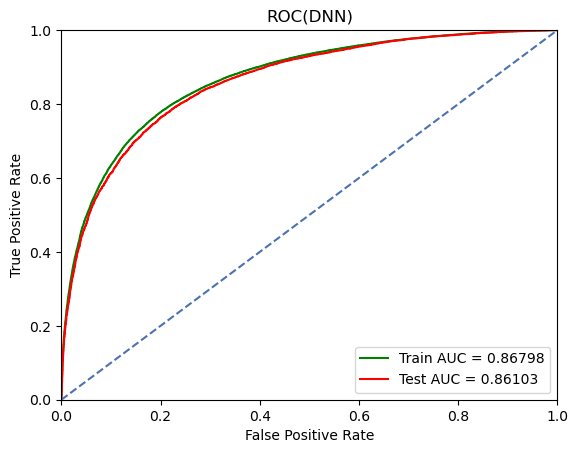

In [31]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(train_label,train_score,sample_weight=train_weight)
roc_auc_train = sklearn.metrics.auc(fpr, tpr)

fprt, tprt, threshold=sklearn.metrics.roc_curve(test_label,test_score,sample_weight=test_weight)
roc_auc_test = sklearn.metrics.auc(fprt, tprt)

plt.style.use('default')
plt.title('ROC(DNN)')
plt.plot(fpr, tpr, 'b',label = 'Train AUC = %0.5f' % roc_auc_train,color='green')
plt.plot(fprt, tprt, 'b',label = 'Test AUC = %0.5f' % roc_auc_test,color='red')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1213/roc-GNN.pdf', format='pdf', dpi=500)
plt.show()